In [1]:
%%capture --no-stderr
%pip install -U langchain_community langchain_google_genai langchain_experimental  langgraph

In [2]:
from google.colab import userdata
gemini_api_key = userdata.get('GEMINI_API_KEY')

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model='gemini-1.5-flash',api_key=gemini_api_key,temprature=0.8)

In [4]:

from pydantic import BaseModel
from langgraph.graph import MessagesState
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage , HumanMessage
# Creating Tools
def workout_planner (query:str):
  ''' Workout planner is a tool that will be called when a user in his query asks about any workout suggestions and some gym related
      queries , then it will provide the user some workout and exercise suggestions.
  '''

  response = llm.invoke(query)
  return response

def Calorie_counter(query:str):
  ''' Calorie counter is a tool that will provide users diet suggestions and calorie count for diets and suggest diet that is beneficial for the health'''
  response = llm.invoke(query)
  return response

tools = [workout_planner , Calorie_counter]
# Binding tools with llm
llm_with_tools = llm.bind_tools(tools)

In [5]:
#Creating Node
sys_msg = SystemMessage(content='You are a gym trainer and workout planner. You have to guide the users effeciently and precisely',name='System')
def Assistant (state:MessagesState)->MessagesState:
  # Instead of adding, create a list of messages
  messages = [sys_msg] + state['messages']
  return {'messages': [llm_with_tools.invoke(messages)]}

In [10]:
from langgraph.graph import StateGraph , START , END
from langgraph.prebuilt import tools_condition , ToolNode
from IPython.display import Image , display
from langgraph.checkpoint.memory import MemorySaver
memory: MemorySaver = MemorySaver()

workflow = StateGraph(MessagesState)
# Adding Nodes
workflow.add_node('Assistant',Assistant)
workflow.add_node('tools',ToolNode(tools))
#Adding Edges
workflow.add_edge(START,'Assistant')
workflow.add_conditional_edges(
     "Assistant",
     #If the response from the assistant is a tool call then it will go the tool and if not it will ends the workflow
     tools_condition,
)
workflow.add_edge('tools','Assistant')
Bot = workflow.compile(checkpointer=memory)



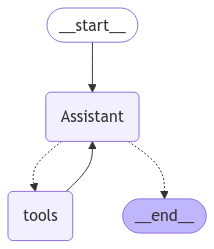

In [7]:
display(Image(Bot.get_graph().draw_mermaid_png()))

In [11]:
# Specify a thread
config1 = {"configurable": {"thread_id": "1"}}

In [12]:
#Invoking the Graph
messages = [HumanMessage(content='I have a chest day today , which exercise will i perform and how many reps , and than tell me about the post workout calorie intake',name='User')]
messages = Bot.invoke({'messages': messages},config=config1)

In [13]:
# Checking the memory
messages = [HumanMessage(content='Which muscle group i was talking about to train',name='User')]
messages = Bot.invoke({'messages': messages},config=config1)

In [14]:
for m in messages['messages']:
  m.pretty_print()

================================ Human Message =================================
Name: User

I have a chest day today , which exercise will i perform and how many reps , and than tell me about the post workout calorie intake
================================== Ai Message ==================================
Tool Calls:
  workout_planner (3b323355-d8d3-49fe-9bcc-50d13476fd26)
 Call ID: 3b323355-d8d3-49fe-9bcc-50d13476fd26
  Args:
    query: chest day workout
================================= Tool Message =================================
Name: workout_planner

content="Here are a few chest day workout options, catering to different experience levels and preferences.  Remember to choose a weight that challenges you while maintaining good form.  Always consult your doctor before starting a new workout routine.\n\n**Workout Option 1: Beginner (Focus on Form)**\n\n* **Incline Dumbbell Press:** 3 sets of 8-12 reps.  This targets the upper chest.\n* **Flat Dumbbell Press:** 3 sets of 8-12 reps. 